## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 5-1. Modeling 1 - RPI Prediction - XGBoost

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5-1. Modeling (1) RPI prediction based on stats - XGboost
- Step 5-2. Modeling (1) RPI prediction based on stats - Linear regression

In [4]:
import pickle 

import pandas as pd
import numpy as np
import seaborn as sn
import xgboost as xgb
import sklearn.model_selection as ms

from datetime import datetime
from scipy import stats

from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)


Yes this finished


In [9]:
y_RPI = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/y_RPI.csv')
y_RPI_2019 = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/y_RPI_2019.csv')
X_famd = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/X_famd.csv')
X_famd_2019 = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/X_famd_2019.csv')
X_College = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/X_College.csv')
X_College_2019 = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/X_College_2019.csv')
X_2019 = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/X_2019.csv')
X = pd.read_csv('/Users/kevin/Dropbox/My Mac (Kevin’s MacBook Pro)/Desktop/softball_ml/Capstone_Softball/Capstone_Softball/Data/X.csv')

print('Yes this finished')

Yes this finished


In [10]:
columns_categorical = X.columns[list(range(16,48))]
columns_categorical
for idx,col in enumerate(columns_categorical):
    X[col] = X[col].astype(int)
    X_2019[col] = X_2019[col].astype(int)

print(X.dtypes)
print(X_2019.dtypes)

IndexError: index 47 is out of bounds for axis 0 with size 47

In [11]:
X = X.drop(columns=['Year'])
X_2019 = X_2019.drop(columns=['Year'])

print('Yes this finished')

KeyError: "['Year'] not found in axis"

In [25]:
y_RPI.to_csv('Data/y_RPI.csv',index=False)
y_RPI_2019.to_csv('Data/y_RPI_2019.csv',index=False)
X.to_csv('Data/X.csv',index=False)
X_2019.to_csv('Data/X_2019.csv',index=False)
X_famd.to_csv('Data/X_famd.csv',index=False)
X_famd_2019.to_csv('Data/X_famd_2019.csv',index=False)
X_College.to_csv('Data/X_College.csv',index=False)
X_College_2019.to_csv('Data/X_College_2019.csv',index=False)



In [41]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [12]:
y = y_RPI
X = X_famd.copy()
X.head()

print('Yes this finished')

Yes this finished


In [35]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


y_train = np.log(y_RPI/(y_RPI.max()+1)/(1-y_RPI/(y_RPI.max()+1)))     #Recreated with Natural Log transformation
y_test = np.log(y_RPI_2019/(y_RPI_2019.max()+1)/(1-y_RPI_2019/(y_RPI_2019.max()+1)))

X_train = X_famd
X_test = X_famd_2019

print(X_train.values[:,0].shape)
print(y_train.shape)

#X_train = X_famd
#y_train = np.log(y_RPI/max(y_RPI)/(1-y_RPI/max(y_RPI)))
#X_test = X_famd_2019
#y_test = np.log(y_RPI_2019/max(y_RPI_2019)/(1-y_RPI_2019/max(y_RPI_2019)))

print('This is finished')

(1771,)
(1771, 1)
This is finished


This is finished


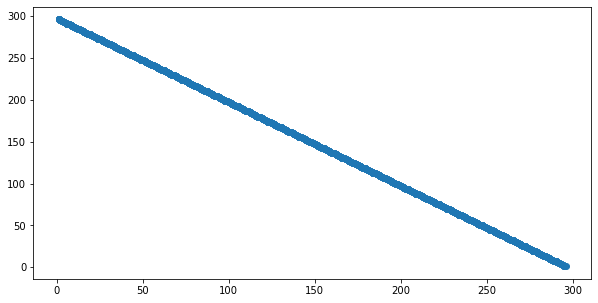

In [44]:
#sample weight
w = y_RPI.max()- y_RPI + 1

#w = (2*np.exp(-0.5*(y_RPI-1)) + 1) * w
plt.scatter(y_RPI,w)

print('This is finished')

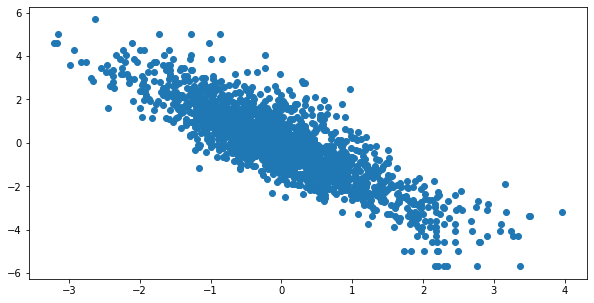

In [36]:
plt.scatter(X_train.values[:,0],y_train)

In [78]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'random_state' :[1]
    #'tweedie_variance_power':[1, 1.2, 1.4, 1.6, 1.8, 2]
}

xg_reg = xgb.XGBRegressor(objective='reg:squarederror',nthread= -1,gpu_id=-1)

print('This is finished')

This is finished


In [79]:
folds = 5
param_comb = 100

random_search1 = RandomizedSearchCV(
    xg_reg, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=folds, 
    verbose=1,
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search1.fit(X_train,y_train,sample_weight = None)
timer(start_time) # timing ends here for "start_time" variable

print('This is finished')

Fitting 5 folds for each of 100 candidates, totalling 500 fits

 Time taken: 0 hours 5 minutes and 49.14 seconds.
This is finished


In [47]:
print('\n All results:')
print(random_search1.cv_results_)
print('\n\n Best estimator:')
print(random_search1.best_estimator_)
print('\n\n Best rmse %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(-random_search1.best_score_)
print('\n\n Best R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X_train)))
print('\n\n Best hyperparameters:')
print(random_search1.best_params_)
results1 = pd.DataFrame(random_search1.cv_results_).sort_values('rank_test_score', ascending=True)
results1.to_csv('XGBoost/xgb-random-grid-search-results-train_famd_exp_kevin.csv', index=False)


 All results:
{'mean_fit_time': array([0.64988561, 1.33672967, 1.34631071, 0.66963673, 1.35075374,
       0.68200903, 1.32767749, 1.36407642, 2.18540807, 1.48750105,
       2.0261281 , 0.64794974, 0.65705161, 0.6599431 , 1.25582962,
       1.86641665, 0.62822523, 0.63323951, 0.63685603, 1.84545717,
       1.85138521, 1.85869374, 1.85413003, 1.24121871, 2.00201621,
       2.01575713, 0.69953418, 2.01958828, 0.69454551, 1.33957419,
       2.01799617, 1.36530447, 1.92407246, 1.27138977, 1.2719183 ,
       1.89020057, 1.26221209, 1.27628717, 1.90043535, 1.90441713,
       1.27220321, 1.25856314, 1.9092185 , 0.64556503, 0.65370936,
       1.26973181, 1.86428823, 1.26855602, 1.85105143, 0.60319977,
       1.24912081, 1.87581472, 1.87804136, 1.86418266, 1.86332607,
       0.61524825, 0.64306302, 1.23024077, 1.82105398, 1.27597728,
       0.68518639, 1.51363688, 2.15899601, 1.36427026, 0.66356587,
       1.26626034, 1.97670512, 1.31903372, 1.93309908, 1.23967261,
       1.23353109, 1.83045759



Best Train R_squared 5-fold search with 100 parameter combinations:
0.94515456119132


Best Test R_squared 5-fold search with 100 parameter combinations:
0.8842647665869876


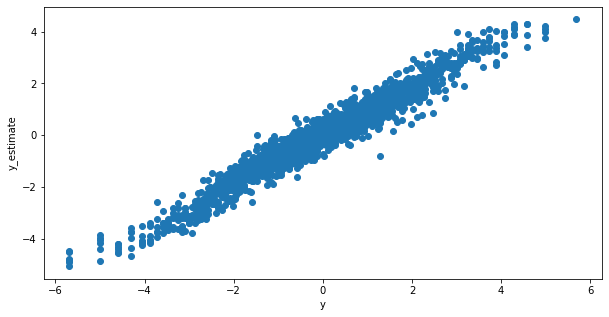

1771 1771 1771
[[  1.]
 [  2.]
 [  3.]
 ...
 [289.]
 [290.]
 [291.]] [-4.473566  -4.4108577 -4.32347   ...  3.4499688  3.7833784  2.713682 ]


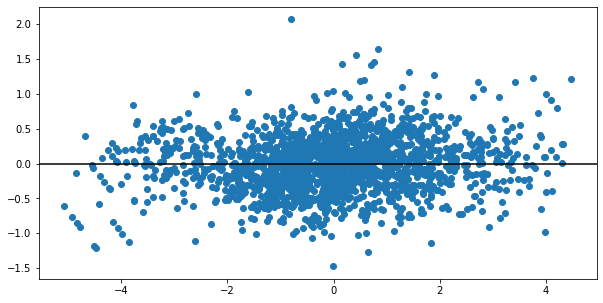

In [85]:
print('\n\nBest Train R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_train, random_search1.predict(X_train)))
print('\n\nBest Test R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_test, random_search1.predict(X_test)))

plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y_train,random_search1.predict(X))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()
print(len(X),len(y),len(random_search1.predict(X)))
print(y.values[:],random_search1.predict(X))
plt.scatter(random_search1.predict(X),y_train.RPI_Ranking-random_search1.predict(X))
plt.axhline(color='black')
plt.show()

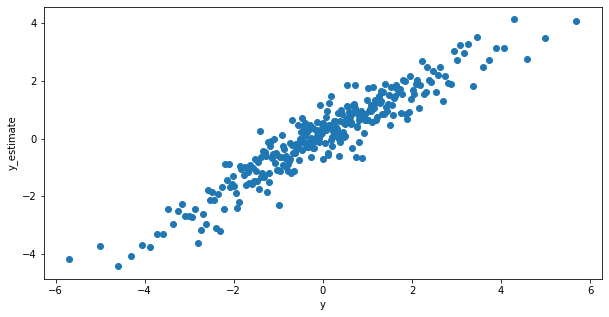

ValueError: Unable to coerce to Series, length must be 1: given 297

In [81]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y_test,random_search1.predict(X_test))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X_test),y_test-random_search1.predict(X_test))
plt.axhline(color='black')
plt.show()

In [60]:
feature_importance1 = pd.DataFrame(X.columns)
feature_importance1.columns = ['Features']
feature_importance1['ImportanceGain'] = random_search1.best_estimator_.feature_importances_
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1['CummulativeGain'] = feature_importance1.ImportanceGain.cumsum()

plt.rcParams['figure.figsize'] = (10, 10)
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1.sort_values('ImportanceGain', ascending=True).plot(x='Features',y='ImportanceGain',kind='barh')
plt.show()

feature_importance1

AttributeError: Feature importance is not defined for Booster type gblinear

### Bootstrap resampling to obtain the predicted RPI distribution

In [61]:
print(random_search1.best_estimator_)
print(random_search1.best_params_)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=12, nthread=-1, num_parallel_tree=None,
             random_state=1, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=1.0, tree_method=None, validate_parameters=1,
             verbosity=None)
{'subsample': 1.0, 'reg_alpha': 0, 'random_state': 1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [62]:
best_xgbmodel = random_search1.best_estimator_
best_xgbmodel.fit(X_train,y_train,sample_weight = w)
fname = 'XGBoost_RPI/xgbmodel_rpi_exp_kevin.obj'
file = open(fname,'wb')
pickle.dump(best_xgbmodel,file)

[12:47:14] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [63]:
# boostrap resampling to generate prediction probability
n_bootstrap = 100
best_xgbmodel_i = random_search1.best_estimator_

y_ex = y_test
X_ex = pd.DataFrame(X_test)
df_y_ex = pd.DataFrame()
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_train)), replace=True, n_samples=len(y_train))
    X_i = X_train.iloc[idx_resample]
    y_i = y_train.iloc[idx_resample]
    w_i = w.iloc[idx_resample]
    best_xgbmodel_i.fit(X_i,y_i,sample_weight = w_i)
    y_ex_est = pd.Series(best_xgbmodel_i.predict(X_ex))
    df_y_ex = df_y_ex.append(y_ex_est,ignore_index = True)
    #fname_i = 'XGBoost_RPI/xgbmodel_rpi_bs_' + str(i_b) + '.obj'
    #file_i = open(fname_i,'wb')
    #pickle.dump(best_xgbmodel,file_i)

df_y_ex.columns = X_College_2019

[12:47:29] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:29] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:29] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

[12:47:31] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:31] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:31] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

[12:47:33] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:33] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:34] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

[12:47:36] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:36] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:36] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

[12:47:38] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:38] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:38] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

In [10]:
'''
n_bootstrap = 100

y_ex = y_test
X_ex = pd.DataFrame(X_test)
df_y_ex = pd.DataFrame()
for i_b in range(n_bootstrap):
    fname_i = 'XGBoost_RPI/xgbmodel_rpi_bs_' + str(i_b) + '.obj'
    file_i = open(fname_i,'rb')
    best_xgbmodel = pickle.load(file_i)
    y_ex_est = pd.Series(best_xgbmodel.predict(X_ex))
    df_y_ex = df_y_ex.append(y_ex_est,ignore_index = True)
    
df_y_ex.columns = X_College_2019
'''

In [65]:
df_y_rank = df_y_ex.rank(axis=1)
df_y_rank
df_y_rank.to_csv('XGBoost_RPI/RPI_prediction_kevin.csv',index = False)

print('This is finished')

This is finished


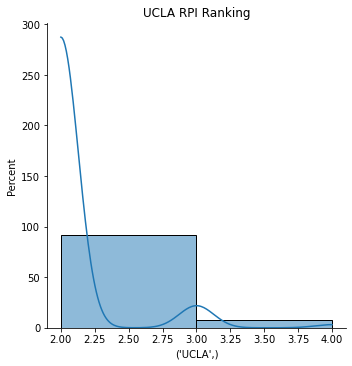

KeyError: 1

In [68]:
idx_ex = 1
college = df_y_rank.columns[idx_ex]
bins = int(np.max(df_y_rank[college]) - np.min(df_y_rank[college]))
sn.displot(data=df_y_rank,x=college,kde=True,bins=bins) 
plt.title(college[0] + ' RPI Ranking')
plt.ylabel('Percent')
plt.show()
print('Actual rank: ', y_ex[idx_ex])
print('Predicted rank: ',df_y_rank[college].value_counts().index[0:2].min())

In [144]:
df_y_rank

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.0,3.0,2.0,10.0,4.0,14.0,15.0,6.0,29.0,7.0,26.0,25.0,17.0,11.0,23.0,19.0,16.0,8.0,21.0,18.0,33.0,35.0,28.0,12.0,9.0,30.0,5.0,40.0,20.0,56.0,54.0,47.0,22.0,42.0,36.0,38.0,32.0,13.0,24.0,52.0,59.0,78.0,48.0,60.0,31.0,62.0,43.0,63.0,88.0,64.0,44.0,37.0,66.0,67.0,45.0,85.0,41.0,175.0,39.0,119.0,55.0,106.0,46.0,126.0,57.0,34.0,103.0,51.0,69.0,97.0,154.0,95.0,99.0,86.0,142.0,68.0,94.0,61.0,74.0,50.0,27.0,82.0,53.0,76.0,140.0,72.0,100.0,89.0,70.0,71.0,91.0,77.0,49.0,92.0,80.0,84.0,104.0,65.0,138.0,115.0,87.0,116.0,58.0,73.0,83.0,75.0,101.0,204.0,105.0,79.0,160.0,111.0,171.0,189.0,81.0,150.0,192.0,139.0,213.0,145.0,141.0,125.0,162.0,107.0,120.0,...,134.0,214.0,109.0,149.0,201.0,133.0,203.0,164.0,169.0,194.0,168.0,163.0,193.0,128.0,200.0,234.0,274.0,179.0,196.0,247.0,211.0,166.0,146.0,123.0,237.0,241.0,250.0,227.0,239.0,98.0,187.0,191.0,235.0,156.0,181.0,182.0,233.0,112.0,210.0,195.0,135.0,198.0,208.0,219.0,212.0,264.0,197.0,253.0,207.0,254.0,245.0,216.0,266.0,188.0,220.0,190.0,186.0,209.0,232.0,243.0,261.0,259.0,267.0,176.0,221.0,165.0,246.0,217.0,202.0,242.0,230.0,177.0,273.0,224.0,155.0,238.0,268.0,244.0,288.0,240.0,281.0,170.0,272.0,262.0,279.0,256.0,223.0,229.0,257.0,228.0,248.0,222.0,225.0,280.0,226.0,285.0,269.0,271.0,29

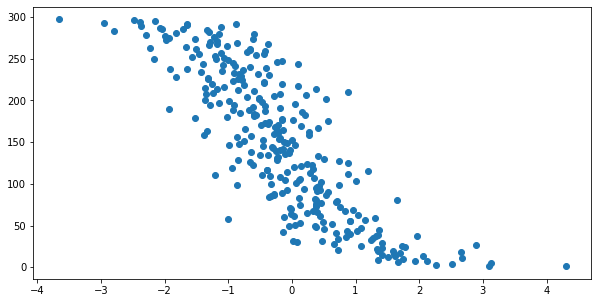

In [76]:

plt.scatter(X_famd_2019.values[:,0],y_RPI_2019.values[:])

In [43]:
y_prop = y_RPI_2019.copy()/max(y_RPI_2019.copy())
y_scaled = np.log(y_prop/(1-y_prop))


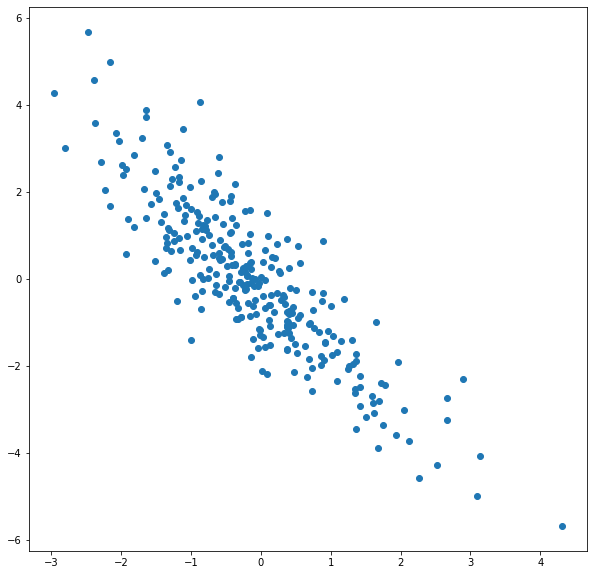

In [116]:
plt.scatter(X_famd_2019[0],y_scaled)

In [173]:
df_y_rank[college].value_counts().index[0:2].min()

1.0

     |████████████████████████████████| 1.2 MB 4.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
